<a href="https://colab.research.google.com/github/florencia-cicarone/tp3-HPC/blob/main/Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introducción

En este cuaderno vamos a realizar la adición de dos imágenes. Para esto lo primero que debemos asegurarnos es que las dos imágenes tengan el mismo tamaño, de no ser asi convertiremos la más chica al tamaño de la más grande. Una vez que tenemos las dos imágenes del mismo tamaño se realiza la sumatoria para cada uno de los 3 canales RGB que representan a los colores R (rojo)-G(verde)-B(azul).
La ecuación que utilizamos para realizar la adición de dos imágenes es la siguiente:

**<center> R = (pixel_R1 / 2) + (pixel_R2 / 2) </center>**
**<center> G = (pixel_G1 / 2) + (pixel_G2 / 2) </center>**
**<center> B = (pixel_B1 / 2) + (pixel_B2 / 2) </center>**

Siendo pixel_R1, pixel_G1, pixel_B1 los canales correspondientes a la primer imágen y pixel_R2, pixel_G2, pixel_B2 los correspondientes a la segunda.

Se utilizo la división por dos en cada canal para evitar desbordes y mejorar la saturación de la imágen final. Y asi mismo logran un mejor efecto con un 50% de cada imágen.
    

# 2. Armado del ambiente


## 2.1 Imágenes

Tomamos la dirección web de dos imagenes con acceso público en internet, las dejamos disponibles al contexto de ejecución del cuaderno Colab.

In [2]:
#@markdown ### Ingrese la dirección URL de la primer imágen
url_imagen1 = "https://fondosmil.com/fondo/88208.jpg" #@param {type:"string"}

#@markdown ---
#@markdown ### Ingrese la dirección URL de la segunda imágen
url_imagen2 = "https://www.wallpapertip.com/wmimgs/77-776836_fondos-de-pantalla-hd-para-pc.jpg" #@param {type:"string"}
#url_imagen2 = "https://s11.favim.com/orig/7/759/7598/75985/pink-aesthetic-sunglasses-Favim.com-7598576.jpg" #@param {type:"string"}


#Leo las imagenes desde internet.
!wget {url_imagen1} -O imagen1.jpg
!wget {url_imagen2} -O imagen2.jpg

--2021-06-24 22:27:25--  https://fondosmil.com/fondo/88208.jpg
Resolving fondosmil.com (fondosmil.com)... 107.150.40.186
Connecting to fondosmil.com (fondosmil.com)|107.150.40.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87776 (86K) [image/jpeg]
Saving to: ‘imagen1.jpg’

imagen1.jpg         100%[===================>]  85.72K   531KB/s    in 0.2s    

2021-06-24 22:27:26 (531 KB/s) - ‘imagen1.jpg’ saved [87776/87776]

--2021-06-24 22:27:26--  https://www.wallpapertip.com/wmimgs/77-776836_fondos-de-pantalla-hd-para-pc.jpg
Resolving www.wallpapertip.com (www.wallpapertip.com)... 204.12.221.198
Connecting to www.wallpapertip.com (www.wallpapertip.com)|204.12.221.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206472 (202K) [image/jpeg]
Saving to: ‘imagen2.jpg’

imagen2.jpg         100%[===================>] 201.63K  --.-KB/s    in 0.09s   

2021-06-24 22:27:26 (2.29 MB/s) - ‘imagen2.jpg’ saved [206472/206472]



## 2.2 Módulo CUDA

Se instala en el cuaderno el módulo CUDA de python.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 24.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627373 sha256=a8c5a36caaf7b21860ab59892357b4487836e58c9e30e361036e3bd91615290c
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=683567fd340d7c8a5da37341a142444bb6820b0c0e915c1c1fb3fd7fcebf5c6d
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


# 3. Desarrollo CPU

Ejecución del algoritmo adición de dos imágenes en CPU.





Imagen1: imagen1.jpg -RGB- [768, 1024]
Imagen2: imagen2.jpg -RGB- [768, 1024]
Imagen resultado: [768, 1024]
Tiempo de conversión de imagen: 17096.84 [ms]
Tiempo Total: 17351.179 [ms]


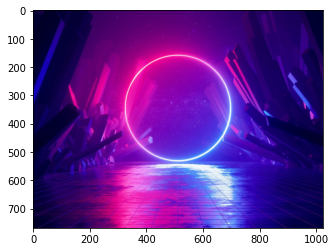

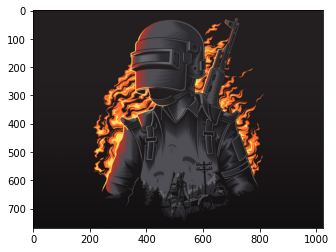

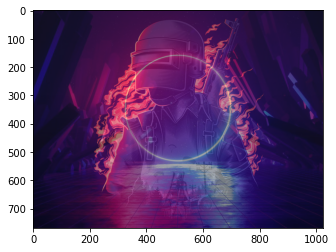

In [3]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img1_nombre = 'imagen1.jpg'
image1 = Image.open( img1_nombre ) 

img2_nombre = 'imagen2.jpg'
image2 = Image.open( img2_nombre ) 

# Optengo las proporsiones de la imagen. 
img1_alto, img1_ancho = image1.size 
img2_alto, img2_ancho = image2.size 

# Si las imagenes no son del mismo tamaño, convierto la mas chica al tamaño de la mas grande
if image1.size > image2.size :
  image2 = image2.resize((img1_alto,img1_ancho))
elif image1.size < image2.size :
  image1 = image1.resize((img2_alto,img2_ancho))

# Optengo la proporsion con la que quedaron ambas imagenes
imagenResultado_alto, imagenResultado_ancho = image1.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img1_pic_cpu = numpy.asarray(image1)
img2_pic_cpu = numpy.asarray(image2)

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
imgResultado_picR_cpu = numpy.empty_like( img1_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes de la adición.
print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )

tiempo_img = datetime.now()

# Realizo la suma de ambas imagenes
for y  in range( 0, imagenResultado_alto ):
  for x in range( 0, imagenResultado_ancho ):
    pixel_R1, pixel_G1, pixel_B1 = img1_pic_cpu[x][y]
    pixel_R2, pixel_G2, pixel_B2 = img2_pic_cpu[x][y]
    R = (pixel_R1 / 2) + (pixel_R2 / 2)
    G = (pixel_G1 / 2) + (pixel_G2 / 2)
    B = (pixel_B1 / 2) + (pixel_B2 / 2)
    imgResultado_picR_cpu[x][y] = [R, G, B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de realizar la suma de ambas.
print("Imagen resultado: " + "[" + str(imagenResultado_ancho) + ", " + str(imagenResultado_alto ) + "]" )  
plt.figure()
imgplot1 = plt.imshow( imgResultado_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# 4. Desarrollo GPU

Ejecución del algoritmo adición de dos imágenes en GPU.


Imagen1: imagen1.jpg -RGB- [768, 1024]
Imagen2: imagen2.jpg -RGB- [768, 1024]
Thread: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de Thread: [ 768 , 1026  ]  =  787968
Imagen resultado: [768, 1024]
Tiempo TOTAL:  390.854 [ms]
Tiempo GPU  :  0.21 [ms]


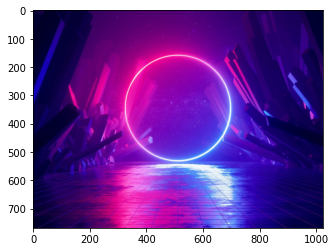

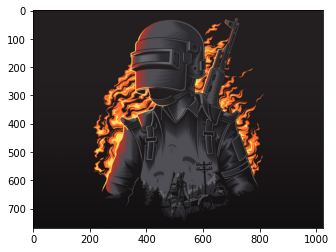

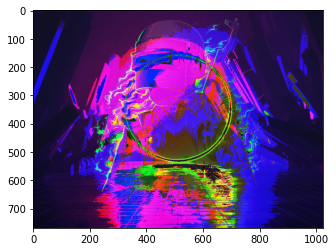

In [13]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img1_nombre = 'imagen1.jpg'
image1 = Image.open( img1_nombre ) 

img2_nombre = 'imagen2.jpg'
image2 = Image.open( img2_nombre ) 

# Optengo las proporsiones de la imagen. 
img1_alto, img1_ancho = image1.size 
img2_alto, img2_ancho = image2.size 

# Si las imagenes no son del mismo tamaño, convierto la mas chica al tamaño de la mas grande
if image1.size > image2.size :
  image2 = image2.resize((img1_alto,img1_ancho))
elif image1.size < image2.size :
  image1 = image1.resize((img2_alto,img2_ancho))

# Optengo la proporsion con la que quedaron ambas imagenes
imagenResultado_alto, imagenResultado_ancho = image1.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img1_pic_cpu = numpy.asarray(image1)
img2_pic_cpu = numpy.asarray(image2)

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
imgResultado_picR_cpu = numpy.empty_like( img1_pic_cpu)

# Reservos los 3 vectores en GPU (3 pixeles usa RGB * el tamaño del array)
img1_pic_gpu = cuda.mem_alloc( img1_pic_cpu.nbytes)
img2_pic_gpu = cuda.mem_alloc( img2_pic_cpu.nbytes)
imgResultado_picR_gpu = cuda.mem_alloc( imgResultado_picR_cpu.nbytes)

# GPU - Copio la memoria al GPU
cuda.memcpy_htod( img1_pic_gpu, img1_pic_cpu )
cuda.memcpy_htod( img2_pic_gpu, img2_pic_cpu )
cuda.memcpy_htod( imgResultado_picR_gpu, imgResultado_picR_cpu )

#CPU - Defino la función kernel que ejecutará en GPU
##revisar en esta parte si se pueden enviar las imagenes como imagenes en vez de como char!
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img1, char *img2, char *imgRes )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fR = 0.0;
  float fG = 0.0;
  float fB = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fR = (float)((img1[(idx+(idy*ancho))*3]/2)+(img2[(idx+(idy*ancho))*3]/2));  // Componente Rojo del pixel.
    fG =(float)((img1[((idx+(idy*ancho))*3)+1]/2)+(img2[((idx+(idy*ancho))*3)+1]/2));  // Componente Verde del pixel.
    fB =(float)((img1[((idx+(idy*ancho))*3)+2]/2)+(img2[((idx+(idy*ancho))*3)+2]/2));   // Componente Azul del pixel.
    
    // Escribo el color del pixel.
    imgRes[(idx+(idy*ancho))*3  ] = (char) fR;
    imgRes[(idx+(idy*ancho))*3+1] = (char) fG;
    imgRes[(idx+(idy*ancho))*3+2] = (char) fB;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes de la adición.
print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )

#CPU - Genero la función kernel.
kernel =  module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (imagenResultado_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (imagenResultado_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(imagenResultado_ancho), numpy.int32(imagenResultado_alto), img1_pic_gpu, img2_pic_gpu, imgResultado_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( imgResultado_picR_cpu, imgResultado_picR_gpu )

# Muestro la imagen luego de realizar la suma de ambas.
print("Imagen resultado: " + "[" + str(imagenResultado_ancho) + ", " + str(imagenResultado_alto ) + "]" )  
plt.figure()
imgplot1 = plt.imshow( imgResultado_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

# 5. Métricas

# 6. Conclusiones

# 7. Bibliografía



*   https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb
*   http://dis.um.es/~ginesgm/files/doc/pi/tema2.pdf

